## 1. 데이터

학번이 짝수로 끝나므로 wine_review.csv 데이터를 분석한다.

In [11]:
!pip install pandas
!pip install nltk
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


# 파이썬 3.11.5 버전에서 진행하였다.

## 2. 데이터 전처리

## 데이터 정리

In [12]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# 데이터 로드 (인코딩 설정 추가)
data = pd.read_csv('./wine_review.csv', encoding='ISO-8859-1')
# 어느순간 read 과정에서 인코딩 오류가 생겨 추가

data = pd.read_csv('./wine_review.csv', encoding='ISO-8859-1')
# 데이터 확인
print(data.head())

                     id asins            brand  \
0  AV13ClKCGV-KLJ3akN68   NaN            Gallo   
1  AV13CsvW-jtxr-f38AQO   NaN  Fresh Craft Co.   
2  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
3  AV13CVI_glJLPUi8O7Po   NaN     1000 Stories   
4  AV13CYL4-jtxr-f37_-t   NaN     Wine Cube153   

                                          categories             dateAdded  \
0  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:11Z   
1  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:59:42Z   
2  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
3  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:05Z   
4  Food & Beverage,Beverages,Wine, Beer & Liquor,...  2017-07-24T23:58:18Z   

            dateUpdated                                       descriptions  \
0  2018-01-10T18:06:28Z                                                NaN   
1  2018-01-10T05:38:33Z  [{"dateSeen":["2017-12-21T05:43:00.000Z","2017...

In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2890 non-null   object 
 1   asins                 870 non-null    object 
 2   brand                 2825 non-null   object 
 3   categories            2890 non-null   object 
 4   dateAdded             2890 non-null   object 
 5   dateUpdated           2890 non-null   object 
 6   descriptions          2738 non-null   object 
 7   dimension             1838 non-null   object 
 8   ean                   2166 non-null   object 
 9   flavors               151 non-null    object 
 10  keys                  2890 non-null   object 
 11  manufacturer          849 non-null    object 
 12  manufacturerNumber    2457 non-null   object 
 13  name                  2890 non-null   object 
 14  reviews.date          2552 non-null   object 
 15  reviews.dateAdded    

In [14]:
# 필요한 열 선택
wine_selected_columns = [
    'brand',
    'reviews.rating'
]

# 선택한 열로 데이터 필터링
wine_data = data[wine_selected_columns]

# 브랜드 별 평균 평점 계산
brand_avg_rating = wine_data.groupby('brand')['reviews.rating'].mean()

# 브랜드별 데이터 개수 계산
brand_counts = data['brand'].value_counts()

# 데이터프레임으로 변환하여 병합
brand_stats = pd.DataFrame({'평균 평점': brand_avg_rating, '데이터 개수': brand_counts})

# 데이터 정렬 (데이터 개수 기준으로 내림차순)
brand_stats_sorted = brand_stats.sort_values(by='데이터 개수', ascending=False)

# 결과 출력
print("브랜드별 데이터 개수와 평균 평점 (내림차순 정렬):")
print(brand_stats_sorted)


브랜드별 데이터 개수와 평균 평점 (내림차순 정렬):
                          평균 평점  데이터 개수
brand                                  
Carmex                 4.878049    1045
Master of Mixes        4.555556     138
Jim Beam               4.902256     133
Bittermens             4.566667     128
Great Value            3.651163     114
...                         ...     ...
Pat O'Brien's               NaN       1
George Killian's       4.000000       1
Beringer               5.000000       1
Belle                  5.000000       1
Robert Mondavi Winery  5.000000       1

[193 rows x 2 columns]


브랜드에 따른 평점을 확인 해 보았을 때 몇몇 브랜드에서 낮은 점수를 보이는것이 눈에 띈다.

하지만 앞으로 진행할 감정 분석에서 brand 열에 결측값 때문에 전체 데이터가 작아지는것을 막기 위하여 brand 열도 제거한다.

In [15]:
#필요한 열만 남기기
wine_selected_columns = [
    'reviews.rating',
    'reviews.text',
    'reviews.title',
]

wine_data = data[wine_selected_columns]

# 결과 확인
print(wine_data.head())

   reviews.rating                                       reviews.text  \
0             5.0      This a fantastic white wine for any occasion!   
1             5.0   Tart, not sweet...very refreshing and delicious!   
2             5.0  I was given this wine so it was a delightful s...   
3             5.0  This is a phenomenal wine and my new favorite ...   
4             5.0  4 750ml bottles for the price of two With way ...   

                          reviews.title  
0                My Favorite White Wine  
1                                 Yum!!  
2                       A New Favorite!  
3  Bold, Flavorful, Aromatic, Delicious  
4  Yum! Plus, Environmentally Friendly!  


In [16]:
print(wine_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.rating  2445 non-null   float64
 1   reviews.text    2889 non-null   object 
 2   reviews.title   2846 non-null   object 
dtypes: float64(1), object(2)
memory usage: 67.9+ KB
None


가장 중요하다고 생각되는 reviews.rating 열에 결측값이 약 450개 가량 존재 하므로 reviews.rating 데이터가 없는 행을 지운다.

In [17]:
# 누락된 데이터 삭제 (결측값 처리)
wine_data= wine_data.dropna()

# 데이터 처리 후 정보 확인
print("데이터 처리 후 정보:")
print(wine_data.info())

데이터 처리 후 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 2406 entries, 0 to 2889
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.rating  2406 non-null   float64
 1   reviews.text    2406 non-null   object 
 2   reviews.title   2406 non-null   object 
dtypes: float64(1), object(2)
memory usage: 75.2+ KB
None


최종적으로 결측값 처리되어 2406 개의 데이터가 남은것을 볼 수 있다.

In [18]:
print(wine_data.head())

   reviews.rating                                       reviews.text  \
0             5.0      This a fantastic white wine for any occasion!   
1             5.0   Tart, not sweet...very refreshing and delicious!   
2             5.0  I was given this wine so it was a delightful s...   
3             5.0  This is a phenomenal wine and my new favorite ...   
4             5.0  4 750ml bottles for the price of two With way ...   

                          reviews.title  
0                My Favorite White Wine  
1                                 Yum!!  
2                       A New Favorite!  
3  Bold, Flavorful, Aromatic, Delicious  
4  Yum! Plus, Environmentally Friendly!  


## 토큰화 및 불용어 제거

불용어 제거를 하기전 reviews.text 열에서 가장 많은 단어의 수를 체크해 보았다.

In [19]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# 각 리뷰의 단어 수를 계산하는 함수 정의
def count_words(text):
    words = word_tokenize(text)  # 텍스트를 토큰화하여 단어로 분리
    return len(words)  # 단어의 개수 반환

# 각 리뷰의 단어 수 계산
wine_data['word_count'] = wine_data['reviews.text'].apply(count_words)

# 가장 많은 단어 수 찾기
max_word_count = wine_data['word_count'].max()

print(f"reviews.text 열에서 가장 많은 단어 수: {max_word_count} 단어")

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


reviews.text 열에서 가장 많은 단어 수: 332 단어


불용어 처리하기전에는 가장 많은 리뷰 단어수가 332 단어이다.

불용어 처리하는 과정에서 토큰화가 이루어졌다

In [20]:
%pip install nltk

## 불용어 처리 과정
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


# NLTK 불용어 세트 다운로드
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') # VADER 감정 분석기에 필요한 어휘 자료를 다운로드

cache = set(stopwords.words("english"))

# 불용어 제거 함수 정의
def remove_stopwords(review):
    words = review.split()  # 텍스트를 단어로 분리 (토큰화)
    filtered_words = [word for word in words if word.lower() not in cache]  # 불용어가 아닌 단어만 선택
    return ' '.join(filtered_words)  # 필터링된 단어들을 다시 문장으로 결합

# reviews.text 열에 불용어 제거 적용
wine_data['reviews.text'] = wine_data['reviews.text'].apply(remove_stopwords)

# reviews.title 열에 불용어 제거 적용
wine_data['reviews.title'] = wine_data['reviews.title'].apply(remove_stopwords)

# 결과 확인
print(wine_data.head())

Note: you may need to restart the kernel to use updated packages.
   reviews.rating                                       reviews.text  \
0             5.0                     fantastic white wine occasion!   
1             5.0           Tart, sweet...very refreshing delicious!   
2             5.0  given wine delightful surprise find flavorful ...   
3             5.0                  phenomenal wine new favorite red.   
4             5.0  4 750ml bottles price two way less packaging Y...   

                          reviews.title  word_count  
0                   Favorite White Wine           9  
1                                 Yum!!          10  
2                         New Favorite!          29  
3  Bold, Flavorful, Aromatic, Delicious          11  
4  Yum! Plus, Environmentally Friendly!          76  


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...


불용어(Stopword) 가 처리 되어 "the", "a", "an" 단어들이 삭제된 것을 확인 할 수 있다.

In [21]:
# 각 리뷰의 단어 수를 계산하는 함수 정의
def count_words(text):
    words = word_tokenize(text)  # 텍스트를 토큰화하여 단어로 분리
    return len(words)  # 단어의 개수 반환

# 각 리뷰의 단어 수 계산
wine_data['word_count'] = wine_data['reviews.text'].apply(count_words)

# 가장 많은 단어 수 찾기
max_word_count = wine_data['word_count'].max()

print(f"reviews.text 열에서 가장 많은 단어 수: {max_word_count} 단어")

reviews.text 열에서 가장 많은 단어 수: 250 단어


가장 많은 단어 수 또한 332 단어에서 250 단어로 감소 된 것을 확인 할 수 있다.

## 텍스트 정규화

In [22]:
# 스테머와 표제어 추출기 초기화
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## 스테밍 :단어의 어간을 추출하는 과정 ( ex) running, ran, runner -> run ) 
# 스테밍 함수 정의
def apply_stemming(review):
    words = word_tokenize(review)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

## 표제어 추출 : 단어의 원형을 추출하는 과정 ( ex) am, are, is -> be )
# 표제어 추출 함수 정의
def apply_lemmatization(review):
    words = word_tokenize(review)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# reviews.text 열에 스테밍 적용
wine_data['reviews.text'] = wine_data['reviews.text'].apply(apply_stemming)

# reviews.title 열에 스테밍 적용
wine_data['reviews.title'] = wine_data['reviews.title'].apply(apply_stemming)

# reviews.text 열에 표제어 추출 적용
wine_data['reviews.text'] = wine_data['reviews.text'].apply(apply_lemmatization)

# reviews.title 열에 표제어 추출 적용
wine_data['reviews.title'] = wine_data['reviews.title'].apply(apply_lemmatization) 

# 결과 확인
print(wine_data.head())

   reviews.rating                                       reviews.text  \
0             5.0                         fantast white wine occas !   
1             5.0             tart , sweet ... veri refresh delici !   
2             5.0  given wine delight surpris find flavor delici ...   
3             5.0                    phenomen wine new favorit red .   
4             5.0  4 750ml bottl price two way le packag ye plea ...   

                        reviews.title  word_count  
0                  favorit white wine           5  
1                             yum ! !           8  
2                       new favorit !          15  
3     bold , flavor , aromat , delici           6  
4  yum ! plu , environment friendli !          37  


## 3. 모델 구현

In [23]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# NLTK에서 VADER lexicon 다운로드
nltk.download('vader_lexicon')

# VADER 감정 분석기 초기화
vader_sentiment = SentimentIntensityAnalyzer()

# 감정 계산 함수 정의
def calc_sentiment(review):
    if review == "No Negative" or review == "No Positive":
        return 0
    return vader_sentiment.polarity_scores(review)["compound"]

# reviews.text 열에 감정 계산 함수 적용
wine_data['text_sentiment'] = wine_data['reviews.text'].apply(calc_sentiment)

# reviews.title 열에 감정 계산 함수 적용
wine_data['title_sentiment'] = wine_data['reviews.title'].apply(calc_sentiment)

# 결과 확인
print(wine_data.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...


   reviews.rating                                       reviews.text  \
0             5.0                         fantast white wine occas !   
1             5.0             tart , sweet ... veri refresh delici !   
2             5.0  given wine delight surpris find flavor delici ...   
3             5.0                    phenomen wine new favorit red .   
4             5.0  4 750ml bottl price two way le packag ye plea ...   

                        reviews.title  word_count  text_sentiment  \
0                  favorit white wine           5          0.0000   
1                             yum ! !           8          0.5093   
2                       new favorit !          15          0.7243   
3     bold , flavor , aromat , delici           6          0.0000   
4  yum ! plu , environment friendli !          37          0.8652   

   title_sentiment  
0           0.0000  
1           0.0000  
2           0.0000  
3           0.3818  
4           0.0000  


## 4. 모델 학습 및 튜닝

## 데이터셋 분할

데이터셋을 0.7 : 0.3 비율로 트레인셋과 테스트 셋으로 분할 하였다.

In [24]:
# 특성 및 타겟 변수 설정
X = wine_data[['text_sentiment', 'title_sentiment']]
y = wine_data['reviews.rating']

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 모델 학습 및 하이퍼 파라미터 튜닝

In [25]:
# 랜덤 포레스트 분류기 초기화
clf = RandomForestClassifier(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# 그리드 서치 설정
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

# 모델 학습 및 하이퍼파라미터 튜닝
grid_search.fit(X_train, y_train)

# 최적의 모델 선택
best_model = grid_search.best_estimator_


## 교차 검증 점수 확인

In [26]:
# 교차 검증 점수 확인
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"교차 검증 평균 점수: {cv_scores.mean()}")

교차 검증 평균 점수: 0.8467959587395789


교차 검증 평균 점수 0.8450 으로 높다고 판단된다.

## 5. 모델 평가와 시각화

In [27]:
# 감정 점수와 평점 간의 관계 분석
print(wine_data[['text_sentiment', 'title_sentiment', 'reviews.rating']].corr())

                 text_sentiment  title_sentiment  reviews.rating
text_sentiment         1.000000         0.147282        0.137563
title_sentiment        0.147282         1.000000        0.173846
reviews.rating         0.137563         0.173846        1.000000


감성 점수와 평점간의 관계는 

title_sentiment와 reviews.rating 이 0.147282

text_sentiment와 reviews.rating 이 0.173846 으로 상당히 낮은 것으로 나타난다.


In [28]:
# 테스트 데이터 예측
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# 평가 지표 출력
print("\n분류 모델 성능 평가:")
print(classification_report(y_test, y_pred))


분류 모델 성능 평가:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        31
         2.0       0.00      0.00      0.00         9
         3.0       0.00      0.00      0.00        19
         4.0       0.33      0.01      0.03        67
         5.0       0.83      0.99      0.90       596

    accuracy                           0.82       722
   macro avg       0.23      0.20      0.19       722
weighted avg       0.71      0.82      0.75       722



/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


하지만 데이터 예측의 결과를 보면 정확도는 0.82로 상당히 높은 것을 알 수 있었다.

precision : 모델이 해당 클래스로 예측한 샘플 중 실제로 해당 클래스인 샘플의 비율

recall : 실제 해당 클래스인 샘플 줄 모델이 해당 클래스로 정확히 예측한 비율

f1-score : 정밀도와 재현율의 조화 평균

surpport : 각 클래스의 실제 샘플 수

1,2,3 평점에 대한 precision,recall,f1-score 가 모두 0이고, 5 점에 대한 예측 수는 매우 높은 것을 확인 할 수 있다. 사실상 대부분의 평점을 5로 예측한 것으로 볼 수 있다.


전체 ROC-AUC 점수: 0.6735587216841701


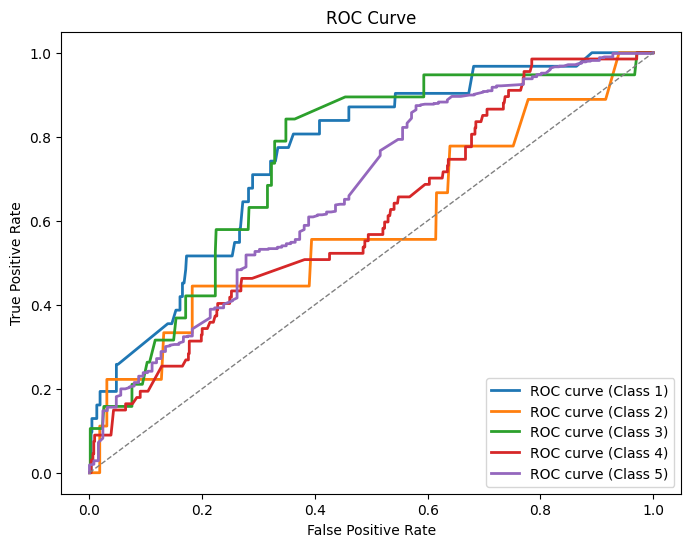

In [29]:
# ROC 곡선 및 ROC-AUC 점수 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"\n전체 ROC-AUC 점수: {roc_auc}")

# 각 클래스별 ROC 곡선 그리기
plt.figure(figsize=(8, 6))
classes = [1, 2, 3, 4, 5]  # 실제 클래스 목록
for i, cls in enumerate(classes):  # 각 클래스에 대해 반복
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=cls)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {cls})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


ROC-AUC 점수는 0.6735 로 나름 준수 하다고는 볼 수 있을 것 같다.

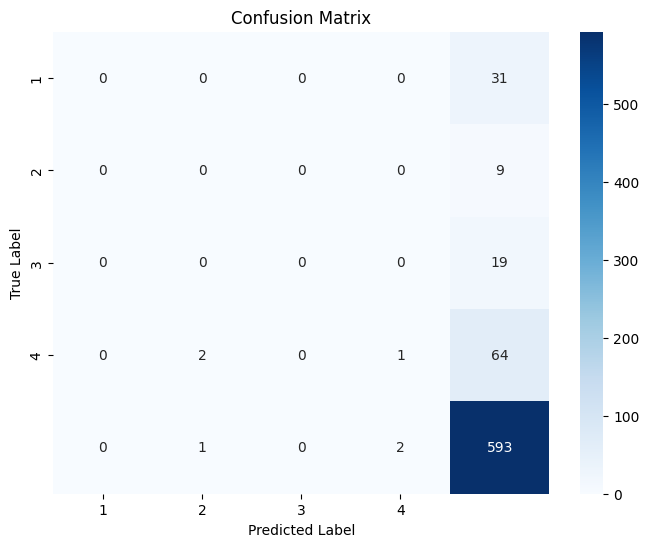

In [30]:
# 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

혼돈 행렬로 시각화 하여 확인해 보았다.

## 오버피팅과 언더피팅

위의 결과는 모델의 정확도도 높았고 ROC-AUC 점수도 준수하긴 하였지만 사실상 대부분의 리뷰 레이팅이 5점이었다.

 따라서 5점으로 예측을 하면 대부분의 예측이 맞는 상황이었고, 따라서 모델을 평가하기엔 힘든 상황이라고 판단하였다. 

따라서 리뷰 레이팅이 5점인 데이터들을 제외하고 모델의 성능을 확인해 보도록 하겠다.

In [34]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# NLTK에서 VADER lexicon 다운로드
nltk.download('vader_lexicon')

# VADER 감정 분석기 초기화
vader_sentiment = SentimentIntensityAnalyzer()

# 감정 계산 함수 정의
def calc_sentiment(review):
    if review == "No Negative" or review == "No Positive":
        return 0
    return vader_sentiment.polarity_scores(review)["compound"]

# 예시 데이터프레임 로드 (실제 데이터프레임을 여기서 로드해야 함)
# wine_data = pd.read_csv("path_to_wine_data.csv")

# reviews.text 열에 감정 계산 함수 적용
wine_data['text_sentiment'] = wine_data['reviews.text'].apply(calc_sentiment)

# reviews.title 열에 감정 계산 함수 적용
wine_data['title_sentiment'] = wine_data['reviews.title'].apply(calc_sentiment)

# 평점이 5인 데이터 제외
low_rating_data = wine_data[wine_data['reviews.rating'].isin([1, 2, 3, 4])]

# 상관 계수 계산
correlation_matrix = low_rating_data[['reviews.rating', 'text_sentiment', 'title_sentiment']].corr()
print("상관 계수 행렬:")
print(correlation_matrix)

# 특성 및 타겟 변수 설정
X = low_rating_data[['text_sentiment', 'title_sentiment']]
y = low_rating_data['reviews.rating']

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 분류기 초기화
clf = RandomForestClassifier(random_state=42)

# 그리드 서치를 사용한 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


상관 계수 행렬:
                 reviews.rating  text_sentiment  title_sentiment
reviews.rating         1.000000        0.262056         0.299398
text_sentiment         0.262056        1.000000         0.234979
title_sentiment        0.299398        0.234979         1.000000
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_sampl


분류 모델 성능 평가:
              precision    recall  f1-score   support

         1.0       0.25      0.16      0.19        19
         2.0       1.00      0.10      0.18        10
         3.0       0.12      0.06      0.08        17
         4.0       0.67      0.90      0.77        71

    accuracy                           0.59       117
   macro avg       0.51      0.30      0.31       117
weighted avg       0.55      0.59      0.52       117


전체 ROC-AUC 점수: 0.6747562565439725


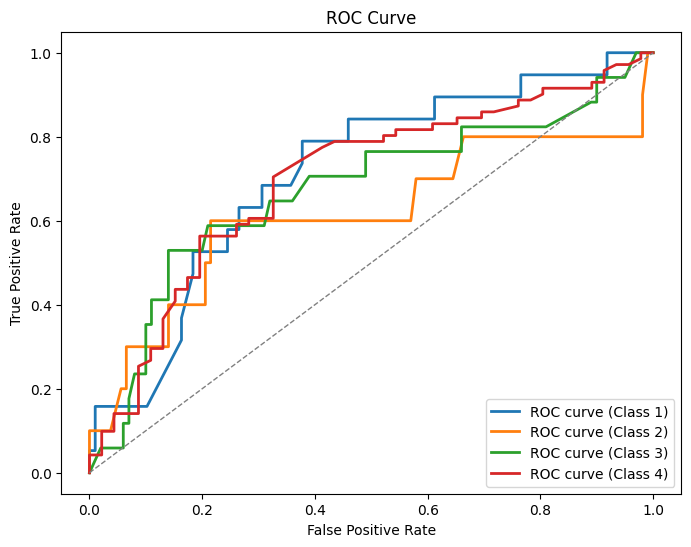

In [33]:
# 평가 지표 출력
print("\n분류 모델 성능 평가:")
print(classification_report(y_test, y_pred))

# ROC-AUC 점수 계산 및 시각화
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"\n전체 ROC-AUC 점수: {roc_auc}")

# 각 클래스별 ROC 곡선 그리기
plt.figure(figsize=(8, 6))
classes = [1, 2, 3, 4]  # 실제 클래스 목록
for i, cls in enumerate(classes):  # 각 클래스에 대해 반복
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=cls)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {cls})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


확실히 대부분의 점수가 5점이었던 기존의 데이터 셋보다 모델의 정확도는 0.59 로 예측하기는 힘든 데이터 였던것으로 확인된다. 데이터셋의 크기가 너무 작아진 것도 이유가 될 수 있을 것으로 판단 된다. 하지만 데이터의 양이 부족 했을 뿐 이전 보다 해당 모델을 평가하기엔 좋은 데이터셋이 라고 판단한다.

ROC-AUC 점수는 0.6747 으로 이전과 비슷한 점수가 나왔고 결국 해당 모델의 점수는 0.67 정도의 점수로 볼 수 있을 것 같다.

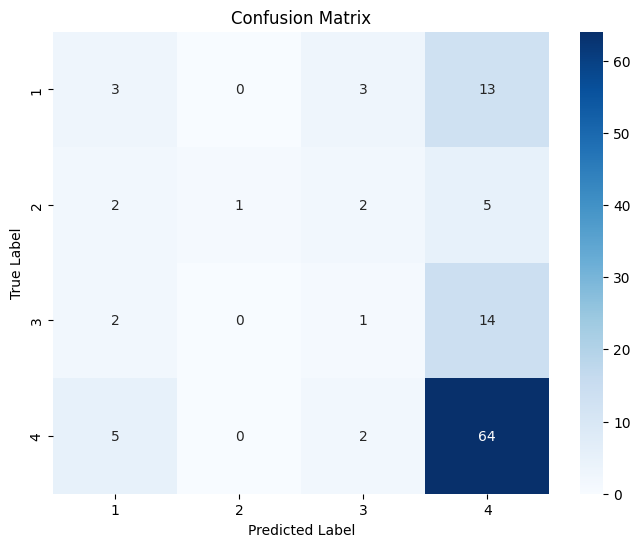

In [32]:
# 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()